# CIFAR-10 Class-Conditional Generation with 4x Super-Resolution

This notebook demonstrates:
1. Loading a trained CIFAR-10 class-conditional PixNerd model
2. Generating images at native 32x32 resolution
3. Generating 4x super-resolution images at 128x128

The model uses the heavy decoder architecture with NerfBlocks that enables
arbitrary resolution output via continuous coordinate embeddings.

## Setup

- Requires GPU
- Assumes model was trained using `train_cifar10.py`
- Update `CKPT_PATH` to point to your trained checkpoint

### Training command:
```bash
python train_cifar10.py --batch_size 128 --max_steps 100000
```

### Model config (must match training):
| Parameter | Value | Why |
|-----------|-------|-----|
| patch_size | 8 | 64 positions for NerfEmbedder (critical for super-res!) |
| hidden_size | 512 | Higher capacity for fewer tokens |
| decoder_hidden_size | 64 | Better super-res quality |
| num_encoder_blocks | 8 | |
| num_groups | 8 | |
| Encoder tokens | 4×4=16 | 32÷8=4 per dimension |

In [2]:
# Navigate to PixNerd folder where src/ is located
import os
import sys

NOTEBOOK_DIR = os.getcwd()
print(f"Starting directory: {NOTEBOOK_DIR}")

# Navigate to PixNerd folder (where src/ lives)
PIXNERD_DIR = os.path.join(NOTEBOOK_DIR, "PixNerd")
if os.path.exists(PIXNERD_DIR):
    os.chdir(PIXNERD_DIR)
    print(f"Changed to: {os.getcwd()}")
elif os.path.basename(NOTEBOOK_DIR) == "PixNerd":
    print(f"Already in PixNerd directory: {NOTEBOOK_DIR}")
else:
    parent = os.path.dirname(NOTEBOOK_DIR)
    pixnerd_in_parent = os.path.join(parent, "PixNerd")
    if os.path.exists(pixnerd_in_parent):
        os.chdir(pixnerd_in_parent)
        print(f"Changed to: {os.getcwd()}")
    else:
        print(f"WARNING: Could not find PixNerd folder. Current dir: {NOTEBOOK_DIR}")

if os.path.exists("src"):
    print("Found src/ directory")
else:
    print("ERROR: src/ directory not found!")

Starting directory: /pscratch/sd/k/kevinval/PNBase
Changed to: /pscratch/sd/k/kevinval/PNBase/PixNerd
Found src/ directory


In [24]:
from pathlib import Path
import math
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Paths
PIXNERD_ROOT = Path(os.getcwd())

# ============================================================
# CHECKPOINT PATH - UPDATE THIS TO YOUR TRAINED MODEL
# ============================================================
# Default path from train_cifar10.py with new super-res config
CKPT_PATH = PIXNERD_ROOT / "workdirs" / "exp_cifar10_c2i_superres_imagenet" / "checkpoints" / "last.ckpt"
# Alternative paths:
# CKPT_PATH = PIXNERD_ROOT / "workdirs" / "exp_cifar10_c2i_heavydecoder" / "checkpoints" / "last.ckpt"
# ============================================================

OUTPUT_DIR = PIXNERD_ROOT / "outputs" / "cifar10_superres"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE != "cuda":
    print("WARNING: Running on CPU will be very slow")

# CIFAR-10 class names
CIFAR10_CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Model config (must match train_cifar10.py defaults)
# CRITICAL: patch_size=8 ensures NerfEmbedder sees 64 positions during training
# This enables proper super-resolution (patch_size=2 only sees 4 corner positions!)
NUM_CLASSES = 10
BASE_RES = 256  # CIFAR-10 native resolution
PATCH_SIZE = 8              # 32/8 = 4x4 = 16 encoder tokens, 64 positions for NerfEmbedder
HIDDEN_SIZE = 512           # Higher capacity for fewer tokens
DECODER_HIDDEN_SIZE = 64    # Better super-res quality
NUM_ENCODER_BLOCKS = 8
NUM_DECODER_BLOCKS = 2
NUM_GROUPS = 8

print(f"PixNerd root: {PIXNERD_ROOT}")
print(f"Checkpoint path: {CKPT_PATH}")
print(f"Checkpoint exists: {CKPT_PATH.exists()}")
if not CKPT_PATH.exists():
    print(f"\n⚠️  CHECKPOINT NOT FOUND!")
    print(f"   Please train a model first using:")
    print(f"   python train_cifar10.py --batch_size 128 --max_steps 100000")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Device: {DEVICE}")
print(f"\nModel config: patch_size={PATCH_SIZE}, hidden={HIDDEN_SIZE}, decoder={DECODER_HIDDEN_SIZE}")
print(f"Encoder tokens: {BASE_RES//PATCH_SIZE}x{BASE_RES//PATCH_SIZE} = {(BASE_RES//PATCH_SIZE)**2}")
print(f"NerfEmbedder positions per patch: {PATCH_SIZE}x{PATCH_SIZE} = {PATCH_SIZE**2}")

PixNerd root: /pscratch/sd/k/kevinval/PNBase/PixNerd
Checkpoint path: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_imagenet/checkpoints/last.ckpt
Checkpoint exists: True
Output directory: /pscratch/sd/k/kevinval/PNBase/PixNerd/outputs/cifar10_superres
Device: cuda

Model config: patch_size=8, hidden=512, decoder=64
Encoder tokens: 32x32 = 1024
NerfEmbedder positions per patch: 8x8 = 64


## Build Model

In [3]:
# Import PixNerd components
from src.models.autoencoder.pixel import PixelAE
from src.models.conditioner.class_label import LabelConditioner
from src.models.transformer.pixnerd_c2i_heavydecoder import PixNerDiT
from src.diffusion.flow_matching.scheduling import LinearScheduler
from src.diffusion.flow_matching.sampling import EulerSampler, ode_step_fn
from src.diffusion.base.guidance import simple_guidance_fn
from src.diffusion.flow_matching.training import FlowMatchingTrainer
from src.callbacks.simple_ema import SimpleEMA
from src.lightning_model import LightningModel
from src.models.autoencoder.base import fp2uint8

print("Imports successful!")

/pscratch/sd/k/kevinval/envs/pixnerd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports successful!


In [25]:
print("Initializing model components...")

main_scheduler = LinearScheduler()

vae = PixelAE(scale=1.0)

conditioner = LabelConditioner(num_classes=NUM_CLASSES)

denoiser = PixNerDiT(
    in_channels=3,
    patch_size=PATCH_SIZE,
    num_groups=NUM_GROUPS,
    hidden_size=HIDDEN_SIZE,
    decoder_hidden_size=DECODER_HIDDEN_SIZE,
    num_encoder_blocks=NUM_ENCODER_BLOCKS,
    num_decoder_blocks=NUM_DECODER_BLOCKS,
    num_classes=NUM_CLASSES,
)

# Sampler with CFG
sampler = EulerSampler(
    num_steps=50,
    guidance=2.0,
    guidance_interval_min=0.0,
    guidance_interval_max=1.0,
    scheduler=main_scheduler,
    w_scheduler=LinearScheduler(),
    guidance_fn=simple_guidance_fn,
    step_fn=ode_step_fn,
)

# Trainer stub for checkpoint loading
trainer_stub = FlowMatchingTrainer(
    scheduler=main_scheduler,
    lognorm_t=True,
    timeshift=1.0,
)

ema_tracker = SimpleEMA(decay=0.9999)

model = LightningModel(
    vae=vae,
    conditioner=conditioner,
    denoiser=denoiser,
    diffusion_trainer=trainer_stub,
    diffusion_sampler=sampler,
    ema_tracker=ema_tracker,
    optimizer=None,
    lr_scheduler=None,
    eval_original_model=False,
)

model.eval()
model.to(DEVICE)
print(f"Model initialized and moved to {DEVICE}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Initializing model components...


current sampler is ODE sampler, but w_scheduler is enabled


Model initialized and moved to cuda
Total parameters: 126,977,158


## Load Checkpoint

In [26]:
print(f"Loading checkpoint from: {CKPT_PATH}")
ckpt = torch.load(CKPT_PATH, map_location="cpu", weights_only=False)
missing, unexpected = model.load_state_dict(ckpt["state_dict"], strict=False)
print(f"Missing keys: {len(missing)} | Unexpected keys: {len(unexpected)}")
print("Checkpoint loaded successfully!")

Loading checkpoint from: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_imagenet/checkpoints/last.ckpt


RuntimeError: Error(s) in loading state_dict for LightningModel:
	size mismatch for denoiser.y_embedder.embedding_table.weight: copying a param with shape torch.Size([1001, 512]) from checkpoint, the shape in current model is torch.Size([11, 512]).
	size mismatch for ema_denoiser.y_embedder.embedding_table.weight: copying a param with shape torch.Size([1001, 512]) from checkpoint, the shape in current model is torch.Size([11, 512]).

## Helper Functions

NameError: name 'train_loader' is not defined

In [7]:
def set_decoder_scale(scale: float):
    """Set NF decoder patch scaling for super-resolution."""
    for net in [model.denoiser, getattr(model, "ema_denoiser", None)]:
        if net is None:
            continue
        net.decoder_patch_scaling_h = scale
        net.decoder_patch_scaling_w = scale


@torch.no_grad()
def sample_class_conditional(
    class_labels: list,
    height: int = 32,
    width: int = 32,
    seed: int = 42,
    num_steps: int = 50,
    guidance: float = 2.0,
    base_res: int = BASE_RES,
):
    """
    Generate class-conditional images.
    
    Args:
        class_labels: List of class indices (0-9) or names
        height: Output height (32 for native, 128 for 4x super-res)
        width: Output width
        seed: Random seed
        num_steps: ODE solver steps
        guidance: CFG guidance scale
        base_res: Training resolution
    
    Returns:
        Generated images as uint8 tensor
    """
    torch.manual_seed(seed)
    
    # Convert class names to indices if needed
    labels = []
    for label in class_labels:
        if isinstance(label, str):
            label = CIFAR10_CLASSES.index(label.lower())
        labels.append(label)
    
    batch_size = len(labels)
    
    # Set decoder scale for super-resolution
    if height == base_res and width == base_res:
        set_decoder_scale(1.0)
        print(f"Generating at native {base_res}x{base_res}")
    else:
        scale_h = height / float(base_res)
        scale_w = width / float(base_res)
        assert scale_h == scale_w, "Only square scaling supported"
        set_decoder_scale(scale_h)
        print(f"Generating at {height}x{width} ({scale_h:.0f}x super-resolution)")
    
    # Configure sampler
    model.diffusion_sampler.guidance = guidance
    model.diffusion_sampler.num_steps = num_steps
    
    # Generate noise
    noise = torch.randn(batch_size, 3, height, width, device=DEVICE)
    
    # Get condition and uncondition
    condition, uncondition = model.conditioner(labels)
    condition = condition.to(DEVICE)
    uncondition = uncondition.to(DEVICE)
    
    # Sample
    samples = model.diffusion_sampler(
        model.ema_denoiser,
        noise,
        condition,
        uncondition,
    )
    
    # Decode
    images = model.vae.decode(samples)
    images = torch.clamp(images, -1.0, 1.0)
    images_uint8 = fp2uint8(images)
    
    return images_uint8.cpu()


def show_images(images_uint8, labels=None, title="", cols=None):
    """Display a batch of images with labels."""
    if isinstance(images_uint8, torch.Tensor):
        imgs_np = images_uint8.permute(0, 2, 3, 1).cpu().numpy()
    else:
        imgs_np = np.transpose(images_uint8, (0, 2, 3, 1))
    
    n = len(imgs_np)
    if cols is None:
        cols = min(n, 5)
    rows = math.ceil(n / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, (ax, img) in enumerate(zip(axes, imgs_np)):
        ax.imshow(img)
        ax.axis('off')
        if labels is not None:
            label = labels[i]
            if isinstance(label, int):
                label = CIFAR10_CLASSES[label]
            ax.set_title(label)
    
    for ax in axes[n:]:
        ax.axis('off')
    
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def save_grid(images_uint8, filename, labels=None, cols=None):
    """Save images as a grid."""
    if isinstance(images_uint8, torch.Tensor):
        imgs_np = images_uint8.permute(0, 2, 3, 1).cpu().numpy()
    else:
        imgs_np = np.transpose(images_uint8, (0, 2, 3, 1))
    
    imgs = [Image.fromarray(img) for img in imgs_np]
    
    n = len(imgs)
    if cols is None:
        cols = min(n, 5)
    rows = math.ceil(n / cols)
    
    w, h = imgs[0].size
    grid = Image.new("RGB", (cols * w, rows * h))
    for idx, img in enumerate(imgs):
        r, c = divmod(idx, cols)
        grid.paste(img, (c * w, r * h))
    
    out_path = OUTPUT_DIR / filename
    grid.save(out_path)
    print(f"Saved: {out_path}")
    return out_path


print("Helper functions defined.")

Helper functions defined.


## Generate at Native Resolution (32x32)

Generate one sample per class at the native CIFAR-10 resolution.

Generating all 10 classes at 32x32
Generating at native 32x32
Output shape: torch.Size([10, 3, 32, 32])


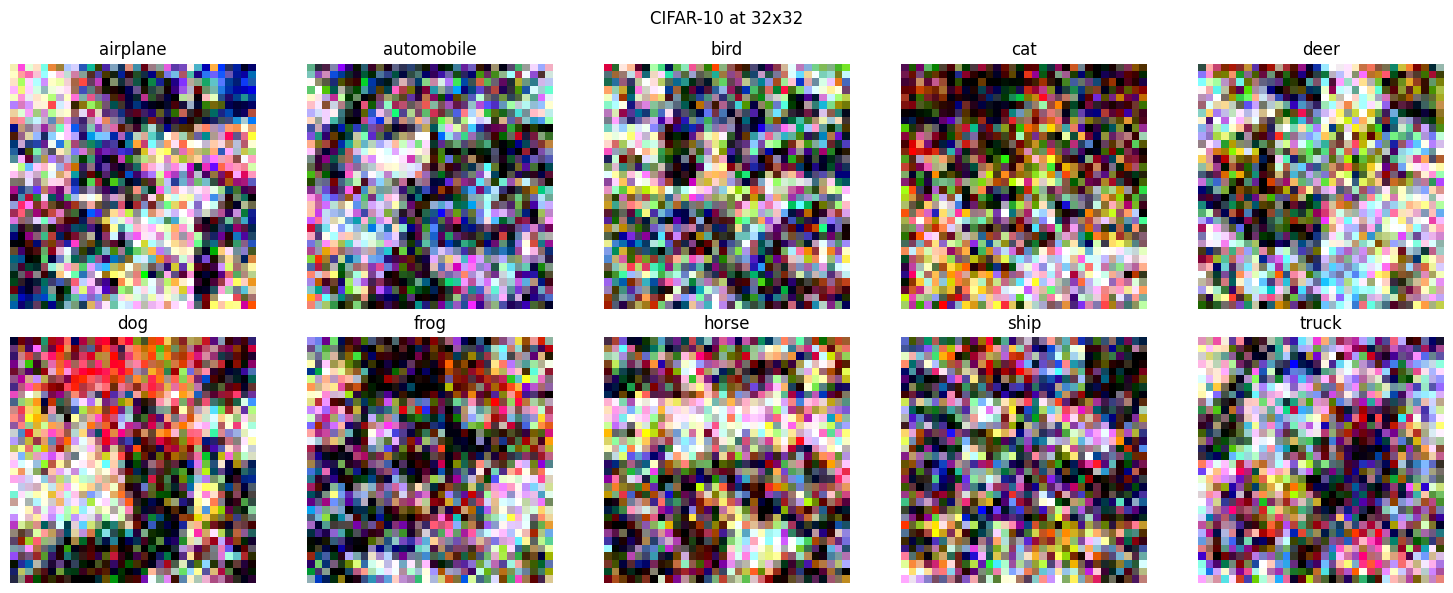

Saved: /pscratch/sd/k/kevinval/PNBase/PixNerd/outputs/cifar10_superres/cifar10_32x32_all_classes.png


PosixPath('/pscratch/sd/k/kevinval/PNBase/PixNerd/outputs/cifar10_superres/cifar10_32x32_all_classes.png')

In [12]:
print("=" * 50)
print("Generating all 10 classes at 32x32")
print("=" * 50)

# Generate one image per class
all_classes = list(range(10))

images_32 = sample_class_conditional(
    class_labels=all_classes,
    height=32,
    width=32,
    seed=42,
    num_steps=50,
    guidance=2.0,
)

print(f"Output shape: {images_32.shape}")
show_images(images_32, labels=CIFAR10_CLASSES, title="CIFAR-10 at 32x32")
save_grid(images_32, "cifar10_32x32_all_classes.png", cols=5)

In [8]:
def make_sparsity_masks(x: torch.Tensor,
                        sparsity: float = 0.4,
                        cond_fraction: float = 0.5):
    """
    Build cond and target masks for sparse conditioning.

    x: (B,C,H,W)
    sparsity: total observed fraction (cond + target), e.g. 0.4
    cond_fraction: fraction of observed used as conditioning, e.g. 0.5 -> 20% cond, 20% target
    """
    B, C, H, W = x.shape
    device = x.device
    total = H * W

    k_obs = int(round(sparsity * total))
    k_obs = max(0, min(total, k_obs))

    if k_obs == 0:
        cond_mask = torch.zeros(B, 1, H, W, device=device)
        target_mask = torch.zeros_like(cond_mask)
        return cond_mask, target_mask

    k_cond = int(round(cond_fraction * k_obs))
    k_cond = max(0, min(k_obs, k_cond))
    k_target = k_obs - k_cond

    cond_mask = torch.zeros(B, 1, H, W, device=device)
    target_mask = torch.zeros_like(cond_mask)

    flat_idx = torch.arange(total, device=device)

    for b in range(B):
        perm = flat_idx[torch.randperm(total, device=device)]
        obs_idx = perm[:k_obs]
        cond_idx = obs_idx[:k_cond]
        target_idx = obs_idx[k_cond:k_cond + k_target]

        cond_mask[b].view(-1)[cond_idx] = 1.0
        target_mask[b].view(-1)[target_idx] = 1.0

    return cond_mask, target_mask


In [9]:
@torch.no_grad()
def reconstruct_sparse_from_gt(
    gt_images: torch.Tensor,
    labels: list,
    sparsity: float = 0.4,
    cond_fraction: float = 0.5,
    num_steps: int = 50,
    guidance: float = 2.0,
    base_res: int = BASE_RES,
):
    """
    Sparse-conditioned reconstruction from GT images.
    The model only 'sees' ~sparsity fraction of pixels (cond + target) in latent space.
    
    Args:
        gt_images: (B,3,H,W) tensor, preprocessed the same way as during training.
                   For now, assume H=W=base_res (32) to avoid super-res complications.
        labels: list of class indices (0-9) or names
        sparsity: total observed fraction (cond + target), e.g. 0.4
        cond_fraction: fraction of observed used for conditioning (hints)
        num_steps: sampler steps
        guidance: CFG guidance scale
        base_res: training resolution (32 for CIFAR-10)
    
    Returns:
        recon_uint8: reconstructed images as uint8 tensor (B,3,H,W)
        cond_mask:   (B,1,H,W) where we gave the model GT hints
        target_mask: (B,1,H,W) where you can compute evaluation loss if you want
    """
    gt_images = gt_images.to(DEVICE)

    B, C, H, W = gt_images.shape
    assert H == base_res and W == base_res, "For now, run sparse recon at base resolution."

    # 1. Encode GT into latent space used by the denoiser
    x_latent = model.vae.encode(gt_images)  # (B,3,32,32) for PixelAE(scale=1.0)

    # 2. Build cond/target masks in latent space
    cond_mask, target_mask = make_sparsity_masks(
        x_latent,
        sparsity=sparsity,
        cond_fraction=cond_fraction,
    )

    # 3. Prepare label conditioning
    label_indices = []
    for lbl in labels:
        if isinstance(lbl, str):
            lbl = CIFAR10_CLASSES.index(lbl.lower())
        label_indices.append(lbl)
    label_indices = torch.tensor(label_indices, device=DEVICE)

    condition, uncondition = model.conditioner(label_indices)
    condition = condition.to(DEVICE)
    uncondition = uncondition.to(DEVICE)

    # 4. Configure sampler
    model.diffusion_sampler.guidance = guidance
    model.diffusion_sampler.num_steps = num_steps

    # 5. Sample starting noise in latent space (same shape as x_latent)
    noise = torch.randn_like(x_latent)

    # 6. Run sparse-conditioned sampling: clamp x_t on cond_mask to x_latent
    samples_latent = model.diffusion_sampler(
        model.ema_denoiser,
        noise,
        condition,
        uncondition,
        cond_mask=cond_mask,
        x_cond=x_latent,
    )

    # 7. Decode to image space
    recon = model.vae.decode(samples_latent)
    recon = torch.clamp(recon, -1.0, 1.0)
    recon_uint8 = fp2uint8(recon)

    return recon_uint8.cpu(), cond_mask.cpu(), target_mask.cpu()


Files already downloaded and verified
Recon shape: torch.Size([8, 3, 32, 32])


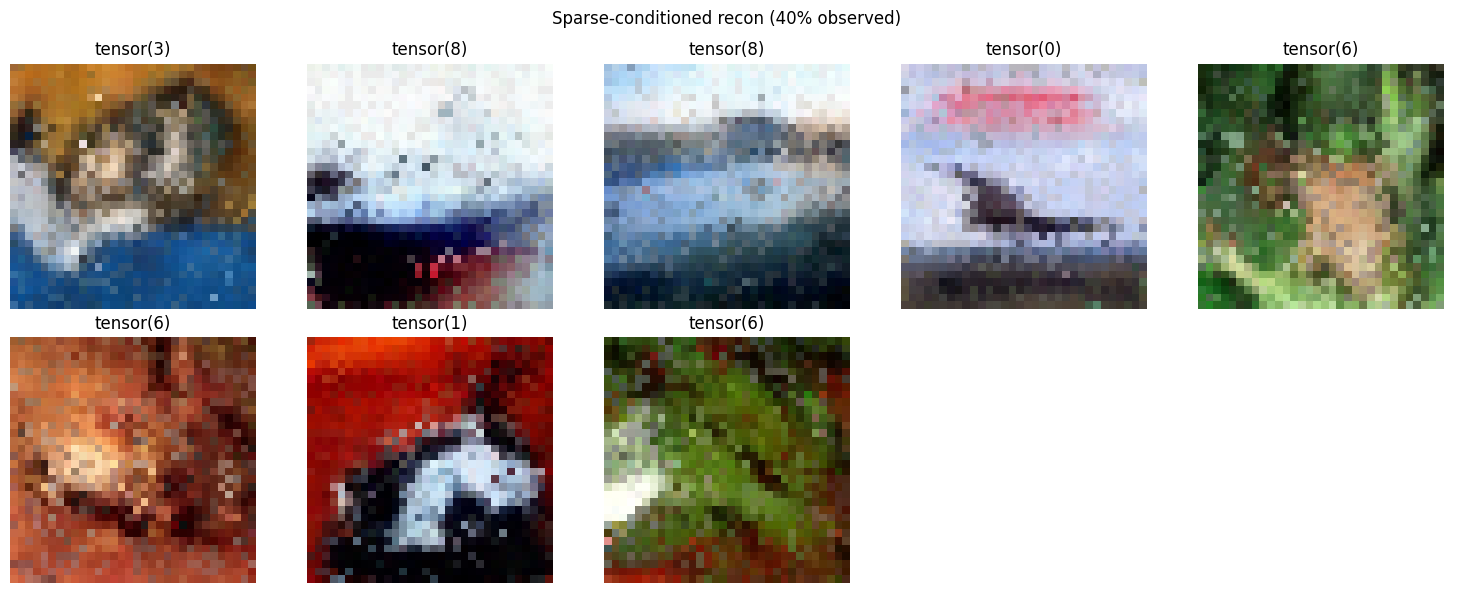

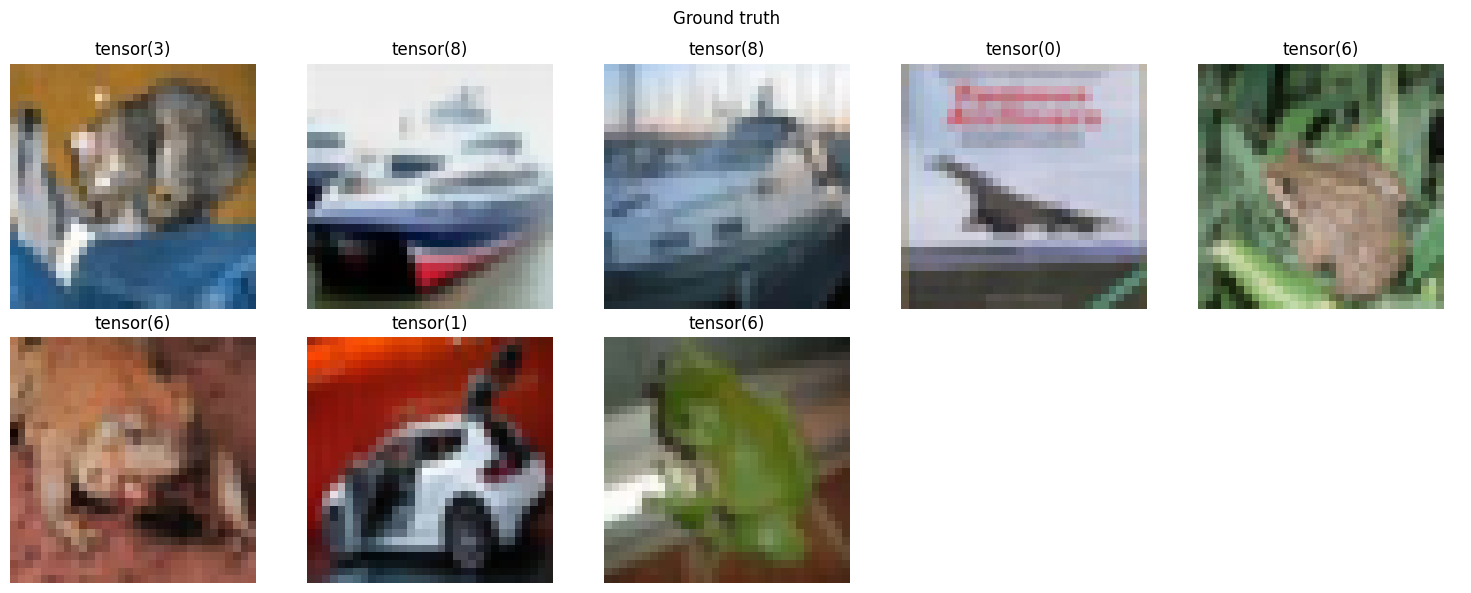

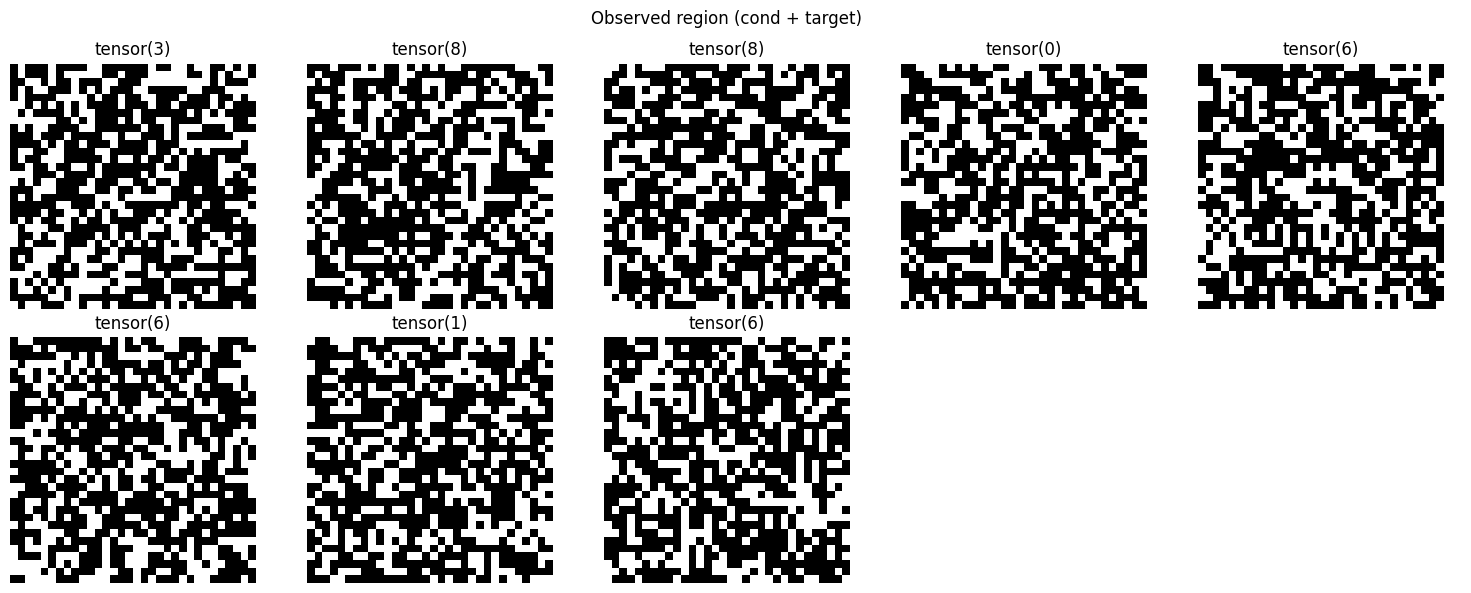

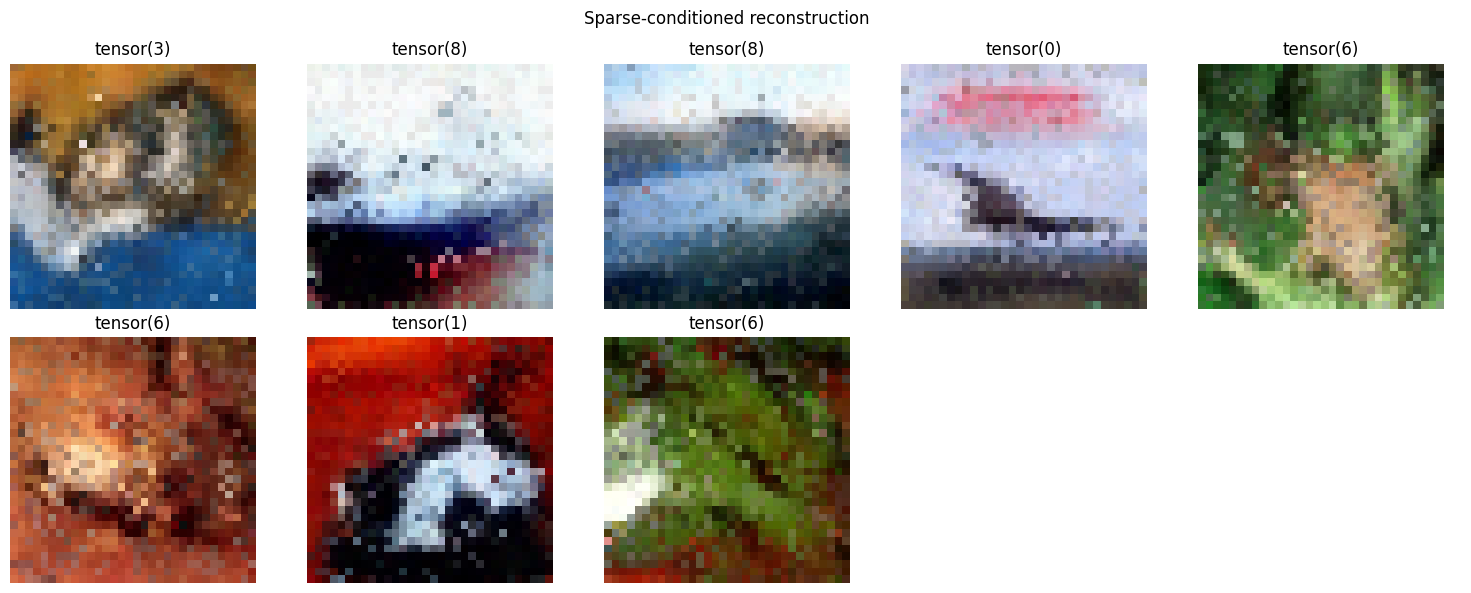

In [16]:
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

# Example: build a small test loader consistent with training transforms
transform = transforms.Compose([
    transforms.ToTensor(),               # [0,1]
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),            # adapt to whatever PixCIFAR10 used
        std=(0.5, 0.5, 0.5),
    ),
])

test_dataset = CIFAR10(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# Get one batch
batch_images, batch_labels = next(iter(test_loader))

# Reconstruct with 40% total sparsity: 20% cond, 20% target
recon_32, cond_mask, target_mask = reconstruct_sparse_from_gt(
    gt_images=batch_images,
    labels=batch_labels.tolist(),
    sparsity=0.4,
    cond_fraction=0.5,
    num_steps=50,
    guidance=2.0,
)

print("Recon shape:", recon_32.shape)
show_images(recon_32, labels=batch_labels, title="Sparse-conditioned recon (40% observed)")

# Visualize cond + target overlay
obs_mask = torch.clamp(cond_mask + target_mask, 0, 1)  # (B,1,H,W)
obs_mask_vis = obs_mask.repeat(1, 3, 1, 1) * 255

show_images(
    fp2uint8(batch_images.to(DEVICE)).cpu(),
    labels=batch_labels,
    title="Ground truth"
)
show_images(
    obs_mask_vis.byte(),
    labels=batch_labels,
    title="Observed region (cond + target)"
)
show_images(
    recon_32,
    labels=batch_labels,
    title="Sparse-conditioned reconstruction"
)


Recon 32 shape: torch.Size([8, 3, 32, 32])


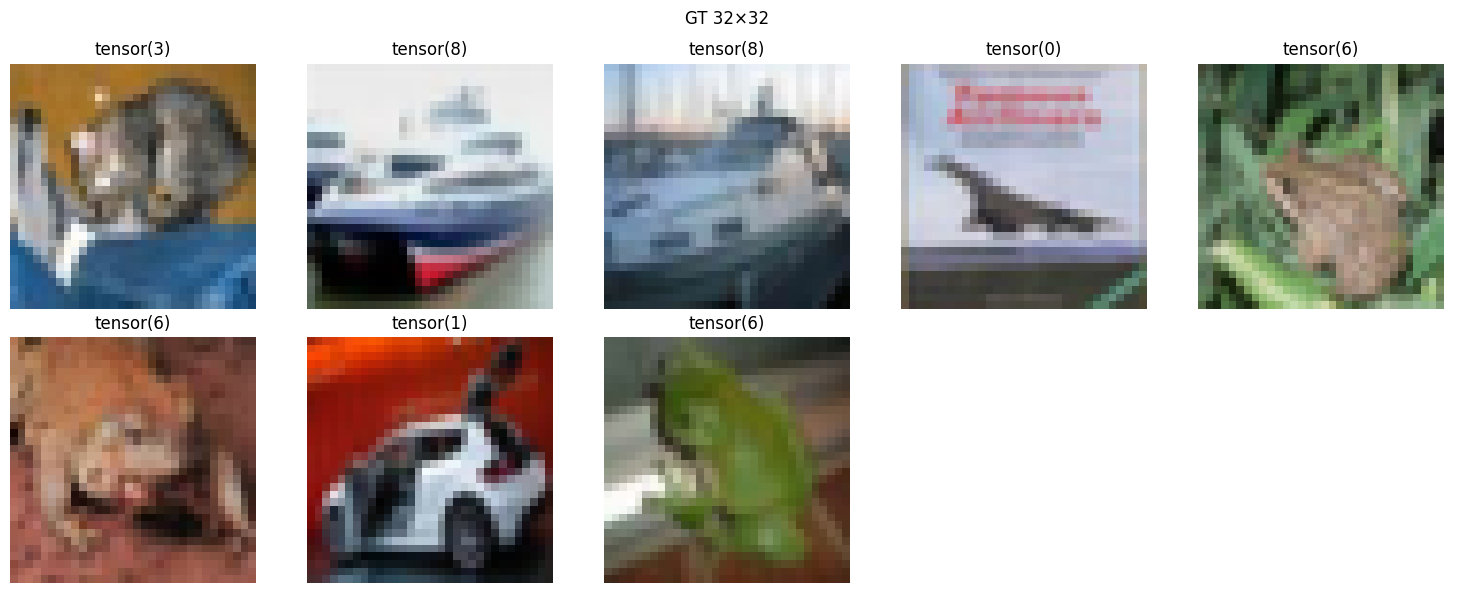

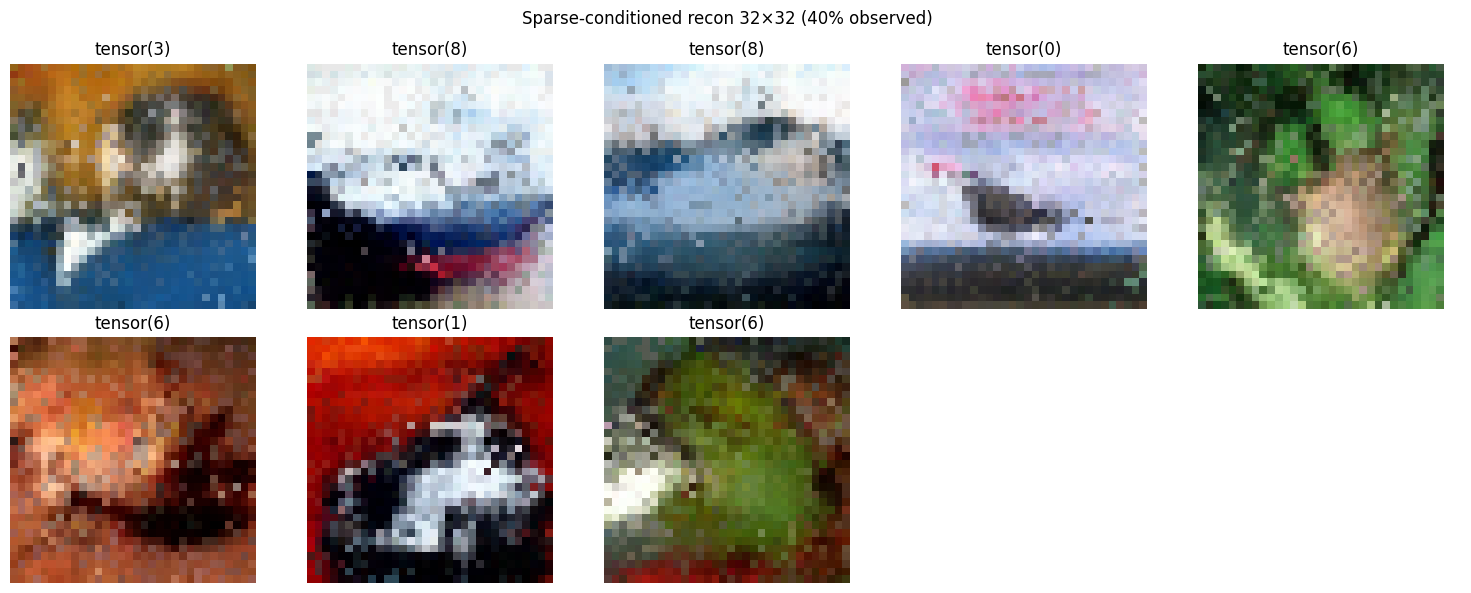

Recon 128 shape: torch.Size([8, 3, 128, 128])


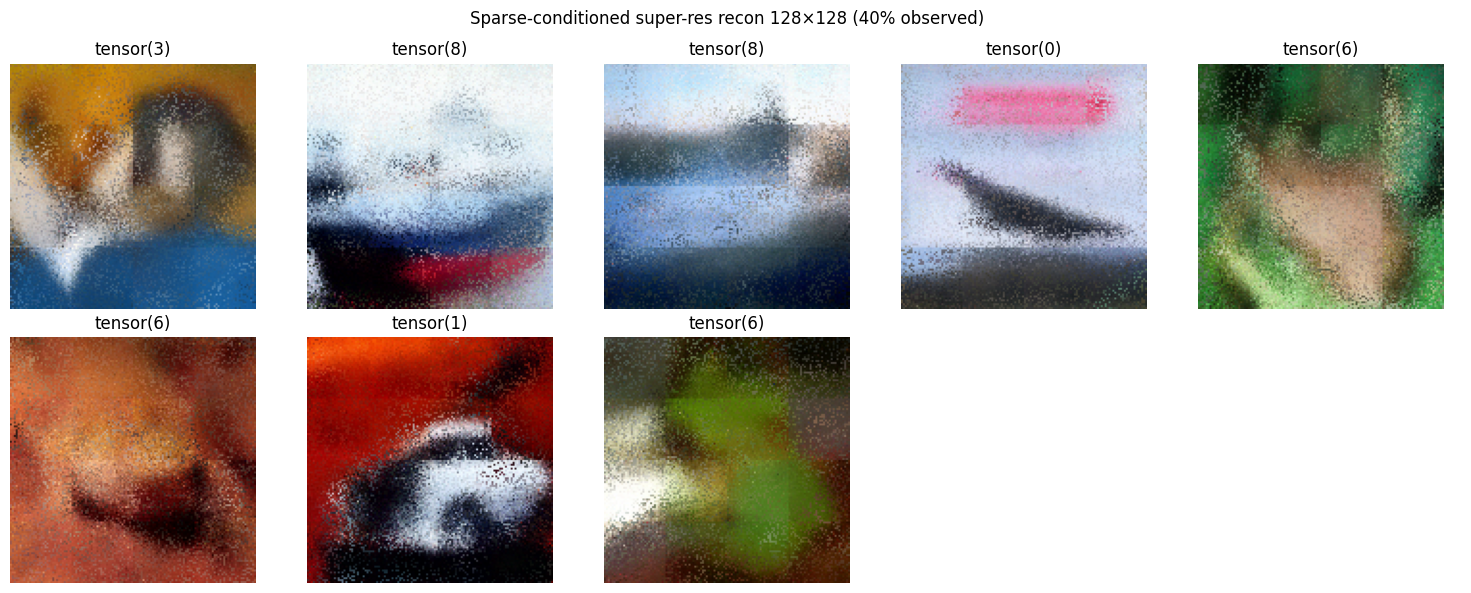

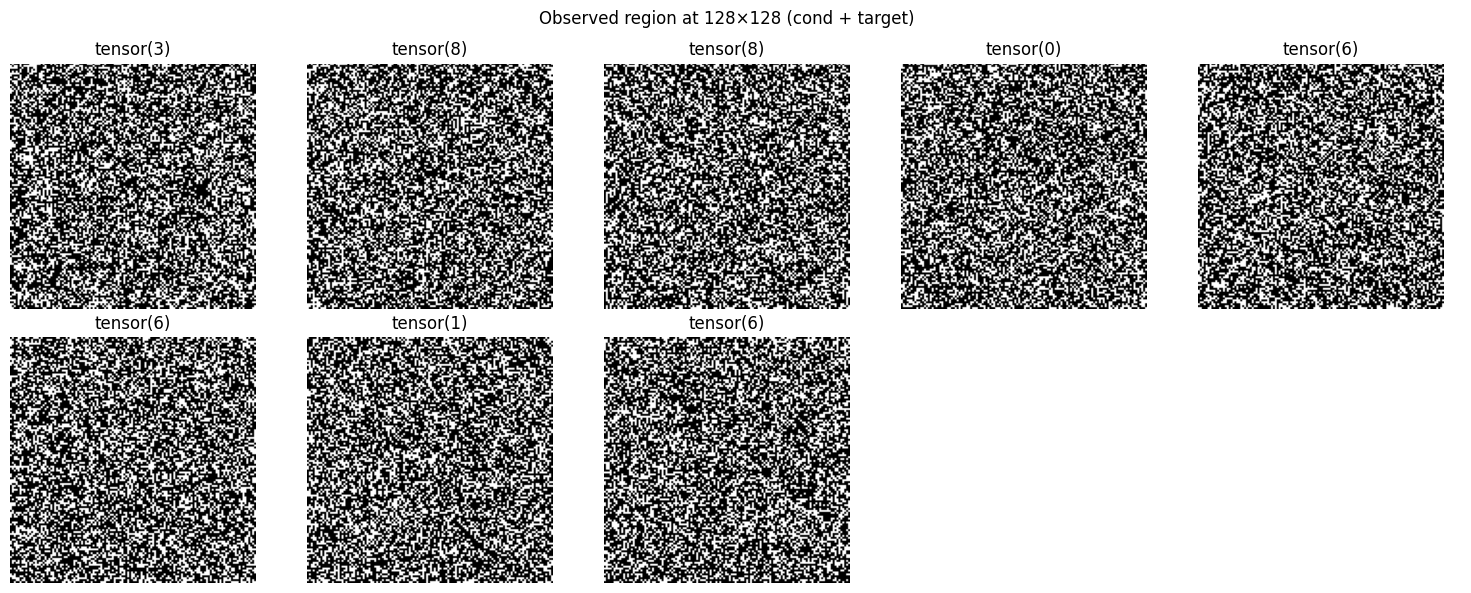

In [14]:
import torch.nn.functional as F

def make_sparsity_masks(x: torch.Tensor,
                        sparsity: float = 0.4,
                        cond_fraction: float = 0.5):
    """
    Build cond and target masks for sparse conditioning.

    x: (B,C,H,W)
    sparsity: total observed fraction (cond + target), e.g. 0.4
    cond_fraction: fraction of observed used as conditioning, e.g. 0.5 -> 20% cond, 20% target
    """
    B, C, H, W = x.shape
    device = x.device
    total = H * W

    k_obs = int(round(sparsity * total))
    k_obs = max(0, min(total, k_obs))

    if k_obs == 0:
        cond_mask = torch.zeros(B, 1, H, W, device=device)
        target_mask = torch.zeros_like(cond_mask)
        return cond_mask, target_mask

    k_cond = int(round(cond_fraction * k_obs))
    k_cond = max(0, min(k_obs, k_cond))
    k_target = k_obs - k_cond

    cond_mask = torch.zeros(B, 1, H, W, device=device)
    target_mask = torch.zeros_like(cond_mask)

    flat_idx = torch.arange(total, device=device)

    for b in range(B):
        perm = flat_idx[torch.randperm(total, device=device)]
        obs_idx = perm[:k_obs]
        cond_idx = obs_idx[:k_cond]
        target_idx = obs_idx[k_cond:k_cond + k_target]

        cond_mask[b].view(-1)[cond_idx] = 1.0
        target_mask[b].view(-1)[target_idx] = 1.0

    return cond_mask, target_mask


@torch.no_grad()
def reconstruct_sparse_from_gt(
    gt_images: torch.Tensor,
    labels: list,
    sparsity: float = 0.4,
    cond_fraction: float = 0.5,
    num_steps: int = 50,
    guidance: float = 2.0,
    base_res: int = BASE_RES,          # 32 for CIFAR-10
    out_height: int | None = None,
    out_width: int | None = None,
):
    """
    Sparse-conditioned reconstruction from GT images.

    - If out_height/out_width == base_res: behaves like the previous 32×32 recon.
    - If out_height/out_width > base_res: does sparse-conditioned *super-resolution*:
      we upsample the GT to (out_height,out_width), reveal only a sparse subset,
      and reconstruct at that higher resolution.

    Args:
        gt_images: (B,3,H,W) tensor, normalized same as training.
        labels: list of class indices (0-9) or names
        sparsity: total observed fraction (cond + target), e.g. 0.4
        cond_fraction: fraction of observed used for conditioning (hints)
        num_steps: sampler steps
        guidance: CFG guidance scale
        base_res: training resolution (32 for CIFAR-10)
        out_height/out_width: desired output resolution. If None, use base_res.

    Returns:
        recon_uint8: reconstructed images as uint8 tensor (B,3,out_height,out_width)
        cond_mask:   (B,1,out_height,out_width)
        target_mask: (B,1,out_height,out_width)
    """
    gt_images = gt_images.to(DEVICE)

    if out_height is None or out_width is None:
        out_height = base_res
        out_width = base_res

    B, C, H_in, W_in = gt_images.shape
    assert H_in == base_res and W_in == base_res, \
        f"Expect input GT at base_res={base_res}, got {H_in}x{W_in}"

    # ------------------------------------------------------------------
    # 1. Decide output resolution & set NF decoder scale
    # ------------------------------------------------------------------
    if out_height == base_res and out_width == base_res:
        scale_h = 1.0
    else:
        scale_h = out_height / float(base_res)
        scale_w = out_width / float(base_res)
        assert abs(scale_h - scale_w) < 1e-6, "Only square scaling supported"
    set_decoder_scale(scale_h)

    # ------------------------------------------------------------------
    # 2. Build the "high-res GT" that we will sparsely reveal
    # ------------------------------------------------------------------
    if out_height == base_res and out_width == base_res:
        gt_hr = gt_images  # (B,3,32,32)
    else:
        # Upsample CIFAR-10 GT to the super-res resolution
        gt_hr = F.interpolate(
            gt_images,
            size=(out_height, out_width),
            mode="bilinear",
            align_corners=False,
        )  # (B,3,out_h,out_w)

    # 3. Encode GT into latent space used by the denoiser (PixelAE is almost identity)
    x_latent = model.vae.encode(gt_hr)  # (B,3,out_h,out_w)

    # 4. Build cond/target masks in *output* resolution
    cond_mask, target_mask = make_sparsity_masks(
        x_latent,
        sparsity=sparsity,
        cond_fraction=cond_fraction,
    )  # shapes (B,1,out_h,out_w)

    # 5. Prepare label conditioning
    label_indices = []
    for lbl in labels:
        if isinstance(lbl, str):
            lbl = CIFAR10_CLASSES.index(lbl.lower())
        label_indices.append(lbl)
    label_indices = torch.tensor(label_indices, device=DEVICE)

    condition, uncondition = model.conditioner(label_indices)
    condition = condition.to(DEVICE)
    uncondition = uncondition.to(DEVICE)

    # 6. Configure sampler
    model.diffusion_sampler.guidance = guidance
    model.diffusion_sampler.num_steps = num_steps

    # 7. Sample starting noise in latent space at the *output* resolution
    noise = torch.randn_like(x_latent)

    # 8. Run sparse-conditioned sampling: clamp x_t on cond_mask to x_latent
    samples_latent = model.diffusion_sampler(
        model.ema_denoiser,
        noise,
        condition,
        uncondition,
        cond_mask=cond_mask,
        x_cond=x_latent,
    )

    # 9. Decode to image space
    recon = model.vae.decode(samples_latent)
    recon = torch.clamp(recon, -1.0, 1.0)
    recon_uint8 = fp2uint8(recon)

    return recon_uint8.cpu(), cond_mask.cpu(), target_mask.cpu()



recon_32, cond_mask_32, target_mask_32 = reconstruct_sparse_from_gt(
    gt_images=batch_images,
    labels=batch_labels.tolist(),
    sparsity=0.4,
    cond_fraction=0.5,
    num_steps=50,
    guidance=2.0,
    out_height=32,
    out_width=32,
)

print("Recon 32 shape:", recon_32.shape)
show_images(
    fp2uint8(batch_images.to(DEVICE)).cpu(),
    labels=batch_labels,
    title="GT 32×32"
)
show_images(
    recon_32,
    labels=batch_labels,
    title="Sparse-conditioned recon 32×32 (40% observed)"
)


recon_128, cond_mask_128, target_mask_128 = reconstruct_sparse_from_gt(
    gt_images=batch_images,
    labels=batch_labels.tolist(),
    sparsity=0.4,
    cond_fraction=0.5,
    num_steps=50,
    guidance=2.0,
    out_height=128,
    out_width=128,
)

print("Recon 128 shape:", recon_128.shape)

# Visualize high-res recon
show_images(
    recon_128,
    labels=batch_labels,
    title="Sparse-conditioned super-res recon 128×128 (40% observed)"
)

# Optional: visualize observed region (cond + target) at 128×128
obs_mask_128 = torch.clamp(cond_mask_128 + target_mask_128, 0, 1)  # (B,1,H,W)
obs_mask_vis_128 = obs_mask_128.repeat(1, 3, 1, 1) * 255

show_images(
    obs_mask_vis_128.byte(),
    labels=batch_labels,
    title="Observed region at 128×128 (cond + target)"
)


In [12]:
@torch.no_grad()
def compute_full_mse(
    gt_images,      # (B,3,H,W), normalized like training ([-1,1] via (x-0.5)/0.5)
    recon_uint8,    # (B,3,H,W), uint8 [0,255]
):
    """
    Compute full-image MSE between GT and reconstruction.
    Returns:
      - per_image_mse: (B,) tensor
      - mean_mse: scalar
    """
    device = recon_uint8.device

    # Move GT to same device as recon
    gt_images = gt_images.to(device)

    # GT: [-1,1] -> [0,1] (since you used mean=0.5, std=0.5)
    gt_01 = (gt_images * 0.5 + 0.5).clamp(0, 1)

    # Recon: uint8 [0,255] -> [0,1]
    recon_01 = recon_uint8.float() / 255.0

    diff2 = (gt_01 - recon_01).pow(2)        # (B,3,H,W)
    per_image_mse = diff2.view(diff2.size(0), -1).mean(dim=1)  # (B,)
    mean_mse = per_image_mse.mean()

    return per_image_mse, mean_mse


PixNerd root: /pscratch/sd/k/kevinval/PNBase/PixNerd
Checkpoint path: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_imagenet/checkpoints/last.ckpt
Checkpoint exists: True
Output directory: /pscratch/sd/k/kevinval/PNBase/PixNerd/outputs/imagenet_superres
Device: cuda

Model config: patch_size=8, hidden=512, decoder=64
Encoder tokens: 32x32 = 1024
Imports successful!
Initializing model components...


current sampler is ODE sampler, but w_scheduler is enabled


Model initialized and moved to cuda
Total parameters: 127,990,918
Loading checkpoint from: /pscratch/sd/k/kevinval/PNBase/PixNerd/workdirs/exp_cifar10_c2i_superres_imagenet/checkpoints/last.ckpt
Missing keys: 0 | Unexpected keys: 0
Checkpoint loaded successfully!
Batch images: torch.Size([4, 3, 256, 256])
Batch labels: tensor([0, 0, 0, 0])
Recon 256 shape: torch.Size([4, 3, 256, 256])


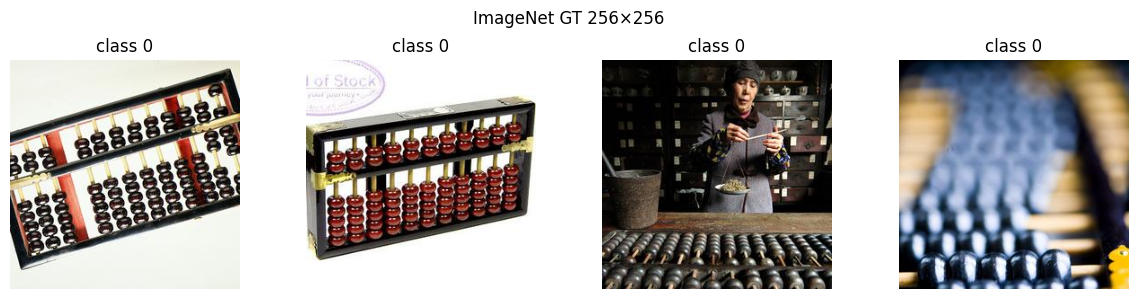

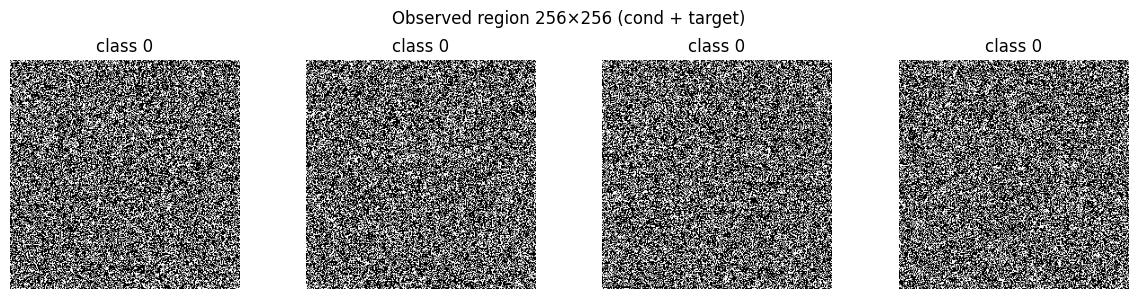

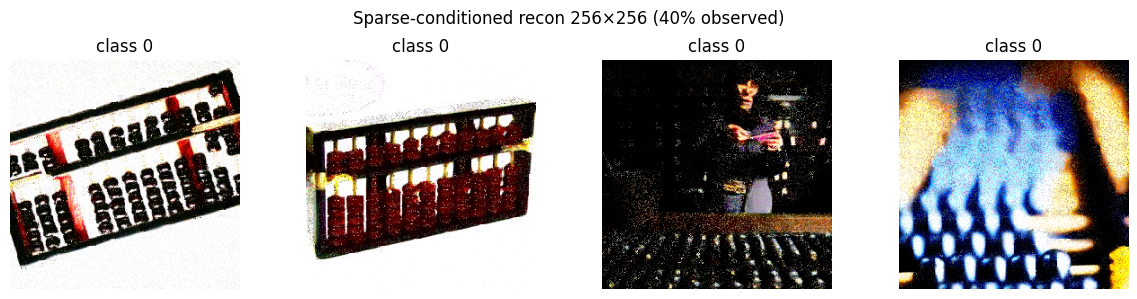

Recon 512 shape: torch.Size([4, 3, 512, 512])


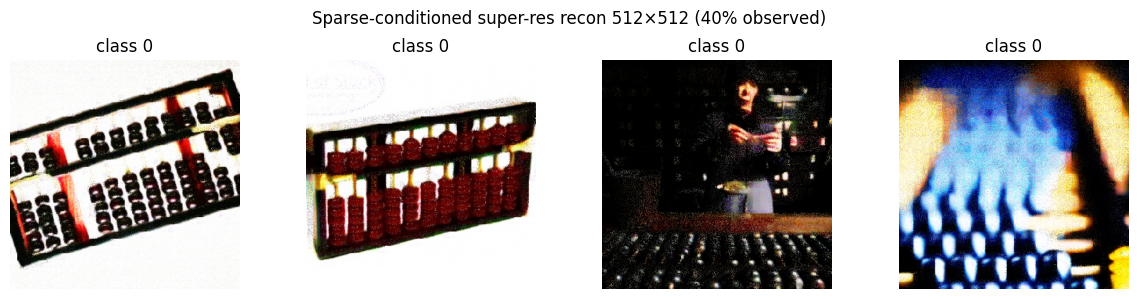

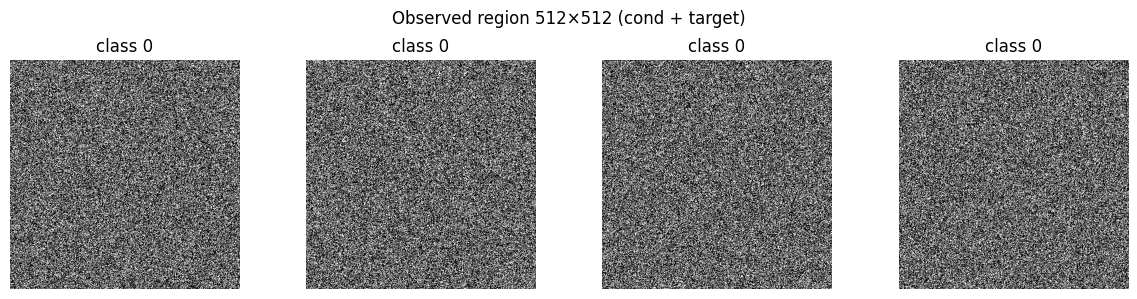


=== 256×256 full-image MSE ===
Per-image MSE: [0.026265492662787437, 0.022288432344794273, 0.04215368628501892, 0.026032602414488792]
Mean MSE:      0.029185054823756218


In [46]:
from pathlib import Path
import os
import math
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# --------------------------------------------------------
# Paths / basic config
# --------------------------------------------------------
PIXNERD_ROOT = Path(os.getcwd())

# CHECKPOINT: adjust if your exp_name is different
CKPT_PATH = (
    PIXNERD_ROOT
    / "workdirs"
    / "exp_cifar10_c2i_superres_imagenet"
    / "checkpoints"
    / "last.ckpt"
)

OUTPUT_DIR = PIXNERD_ROOT / "outputs" / "imagenet_superres"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ImageNet data root
IMAGENET_ROOT = "/pscratch/sd/k/kevinval/datasets/imagenet256"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE != "cuda":
    print("WARNING: Running on CPU will be very slow")

# --------------------------------------------------------
# Model hyperparams (must match training)
# --------------------------------------------------------
NUM_CLASSES = 1000         # <-- set to what you used for training
BASE_RES = 256             # training resolution for ImageNet256
PATCH_SIZE = 8             # 256/8 = 32x32 tokens
HIDDEN_SIZE = 512
DECODER_HIDDEN_SIZE = 64
NUM_ENCODER_BLOCKS = 8
NUM_DECODER_BLOCKS = 2
NUM_GROUPS = 8

print(f"PixNerd root: {PIXNERD_ROOT}")
print(f"Checkpoint path: {CKPT_PATH}")
print(f"Checkpoint exists: {CKPT_PATH.exists()}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Device: {DEVICE}")
print(f"\nModel config: patch_size={PATCH_SIZE}, hidden={HIDDEN_SIZE}, decoder={DECODER_HIDDEN_SIZE}")
print(f"Encoder tokens: {BASE_RES//PATCH_SIZE}x{BASE_RES//PATCH_SIZE} = {(BASE_RES//PATCH_SIZE)**2}")

# --------------------------------------------------------
# Imports from PixNerd
# --------------------------------------------------------
from src.models.autoencoder.pixel import PixelAE
from src.models.conditioner.class_label import LabelConditioner
from src.models.transformer.pixnerd_c2i_heavydecoder import PixNerDiT
from src.diffusion.flow_matching.scheduling import LinearScheduler
from src.diffusion.flow_matching.sampling import EulerSampler, ode_step_fn
from src.diffusion.base.guidance import simple_guidance_fn
from src.diffusion.flow_matching.training import FlowMatchingTrainer
from src.callbacks.simple_ema import SimpleEMA
from src.lightning_model import LightningModel
from src.models.autoencoder.base import fp2uint8

print("Imports successful!")

# --------------------------------------------------------
# Build model (same arch as training)
# --------------------------------------------------------
print("Initializing model components...")

main_scheduler = LinearScheduler()

vae = PixelAE(scale=1.0)

conditioner = LabelConditioner(num_classes=NUM_CLASSES)

denoiser = PixNerDiT(
    in_channels=3,
    patch_size=PATCH_SIZE,
    num_groups=NUM_GROUPS,
    hidden_size=HIDDEN_SIZE,
    decoder_hidden_size=DECODER_HIDDEN_SIZE,
    num_encoder_blocks=NUM_ENCODER_BLOCKS,
    num_decoder_blocks=NUM_DECODER_BLOCKS,
    num_classes=NUM_CLASSES,
)

sampler = EulerSampler(
    num_steps=50,
    guidance=2.0,
    guidance_interval_min=0.0,
    guidance_interval_max=1.0,
    scheduler=main_scheduler,
    w_scheduler=LinearScheduler(),
    guidance_fn=simple_guidance_fn,
    step_fn=ode_step_fn,
)

trainer_stub = FlowMatchingTrainer(
    scheduler=main_scheduler,
    lognorm_t=True,
    timeshift=1.0,
)

ema_tracker = SimpleEMA(decay=0.9999)

model = LightningModel(
    vae=vae,
    conditioner=conditioner,
    denoiser=denoiser,
    diffusion_trainer=trainer_stub,
    diffusion_sampler=sampler,
    ema_tracker=ema_tracker,
    optimizer=None,
    lr_scheduler=None,
    eval_original_model=False,
)

model.eval()
model.to(DEVICE)
print(f"Model initialized and moved to {DEVICE}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# --------------------------------------------------------
# Load checkpoint
# --------------------------------------------------------
print(f"Loading checkpoint from: {CKPT_PATH}")
ckpt = torch.load(CKPT_PATH, map_location="cpu", weights_only=False)
missing, unexpected = model.load_state_dict(ckpt["state_dict"], strict=False)
print(f"Missing keys: {len(missing)} | Unexpected keys: {len(unexpected)}")
if missing:
    print("  Missing (first few):", missing[:10])
if unexpected:
    print("  Unexpected (first few):", unexpected[:10])
print("Checkpoint loaded successfully!")

# --------------------------------------------------------
# Helper: adjust NF decoder scale for super-res
# --------------------------------------------------------
def set_decoder_scale(scale: float):
    """Set NF decoder patch scaling for super-resolution."""
    for net in [model.denoiser, getattr(model, "ema_denoiser", None)]:
        if net is None:
            continue
        if hasattr(net, "decoder_patch_scaling_h"):
            net.decoder_patch_scaling_h = scale
            net.decoder_patch_scaling_w = scale

# --------------------------------------------------------
# Helper: simple image grid visualizer
# --------------------------------------------------------
def show_images(images_uint8, labels=None, title="", cols=None):
    """Display a batch of images with optional labels (int class indices)."""
    if isinstance(images_uint8, torch.Tensor):
        imgs_np = images_uint8.permute(0, 2, 3, 1).cpu().numpy()
    else:
        imgs_np = np.transpose(images_uint8, (0, 2, 3, 1))

    n = len(imgs_np)
    if cols is None:
        cols = min(n, 5)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, (ax, img) in enumerate(zip(axes, imgs_np)):
        ax.imshow((img).astype(np.uint8))
        ax.axis("off")
        if labels is not None and i < len(labels):
            ax.set_title(f"class {int(labels[i])}")
    for ax in axes[n:]:
        ax.axis("off")

    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------
# Sparsity mask helper (same pattern as training)
# --------------------------------------------------------
def make_sparsity_masks(x: torch.Tensor,
                        sparsity: float = 0.4,
                        cond_fraction: float = 0.5):
    """
    Build cond and target masks for sparse conditioning.

    x: (B,C,H,W)
    sparsity: total observed fraction (cond + target), e.g. 0.4
    cond_fraction: fraction of observed used as conditioning, e.g. 0.5 -> 20% cond, 20% target
    """
    B, C, H, W = x.shape
    device = x.device
    total = H * W

    k_obs = int(round(sparsity * total))
    k_obs = max(0, min(total, k_obs))

    if k_obs == 0:
        cond_mask = torch.zeros(B, 1, H, W, device=device)
        target_mask = torch.zeros_like(cond_mask)
        return cond_mask, target_mask

    k_cond = int(round(cond_fraction * k_obs))
    k_cond = max(0, min(k_obs, k_cond))
    k_target = k_obs - k_cond

    cond_mask = torch.zeros(B, 1, H, W, device=device)
    target_mask = torch.zeros_like(cond_mask)

    flat_idx = torch.arange(total, device=device)

    for b in range(B):
        perm = flat_idx[torch.randperm(total, device=device)]
        obs_idx = perm[:k_obs]
        cond_idx = obs_idx[:k_cond]
        target_idx = obs_idx[k_cond:k_cond + k_target]

        cond_mask[b].view(-1)[cond_idx] = 1.0
        target_mask[b].view(-1)[target_idx] = 1.0

    return cond_mask, target_mask

# --------------------------------------------------------
# Sparse recon + (optional) super-res from GT
# --------------------------------------------------------
@torch.no_grad()
def reconstruct_sparse_from_gt(
    gt_images: torch.Tensor,
    labels: torch.Tensor,
    sparsity: float = 0.4,
    cond_fraction: float = 0.5,
    num_steps: int = 50,
    guidance: float = 2.0,
    base_res: int = BASE_RES,
    out_height: int | None = None,
    out_width: int | None = None,
):
    """
    Sparse-conditioned reconstruction from GT images.

    - If out_height/out_width == base_res: base-resolution recon.
    - If out_height/out_width > base_res: sparse-conditioned super-res:
      upsample GT to (out_height,out_width), reveal sparse subset, reconstruct at high-res.

    Args:
        gt_images: (B,3,H,W) tensor, preprocessed as in training.
                   For now assume H=W=base_res.
        labels:   (B,) tensor of class indices in [0, NUM_CLASSES-1]
        sparsity: total observed fraction (cond + target), e.g. 0.4
        cond_fraction: fraction of observed used for conditioning (hints)
        num_steps: sampler steps
        guidance: CFG guidance scale
        base_res: training resolution (256 for ImageNet256)
        out_height/out_width: desired output resolution. If None, use base_res.

    Returns:
        recon_uint8: (B,3,out_h,out_w) reconstructed images as uint8
        cond_mask:   (B,1,out_h,out_w)
        target_mask: (B,1,out_h,out_w)
    """
    gt_images = gt_images.to(DEVICE)
    labels = labels.to(DEVICE)

    if out_height is None or out_width is None:
        out_height = base_res
        out_width = base_res

    B, C, H_in, W_in = gt_images.shape
    assert H_in == base_res and W_in == base_res, \
        f"Expect input GT at base_res={base_res}, got {H_in}x{W_in}"

    # 1. Decide output resolution & adjust decoder scale
    if out_height == base_res and out_width == base_res:
        scale_h = 1.0
    else:
        scale_h = out_height / float(base_res)
        scale_w = out_width / float(base_res)
        assert abs(scale_h - scale_w) < 1e-6, "Only square scaling supported"
    set_decoder_scale(scale_h)

    # 2. Build high-res GT (if super-res)
    if out_height == base_res and out_width == base_res:
        gt_hr = gt_images  # (B,3,256,256)
    else:
        gt_hr = F.interpolate(
            gt_images,
            size=(out_height, out_width),
            mode="bilinear",
            align_corners=False,
        )

    # 3. Encode GT into latent space
    x_latent = model.vae.encode(gt_hr)

    # 4. Build cond/target masks
    cond_mask, target_mask = make_sparsity_masks(
        x_latent,
        sparsity=sparsity,
        cond_fraction=cond_fraction,
    )

    # 5. Label conditioning (no name mapping; ImageNet labels are ints)
    condition, uncondition = model.conditioner(labels)

    # 6. Configure sampler
    model.diffusion_sampler.guidance = guidance
    model.diffusion_sampler.num_steps = num_steps

    # 7. Sample starting noise in latent space
    noise = torch.randn_like(x_latent)

    # 8. Run sparse-conditioned sampling
    samples_latent = model.diffusion_sampler(
        model.ema_denoiser,
        noise,
        condition,
        uncondition,
        cond_mask=cond_mask,
        x_cond=x_latent,
    )

    # 9. Decode to image space
    recon = model.vae.decode(samples_latent)
    recon = torch.clamp(recon, -1.0, 1.0)
    recon_uint8 = fp2uint8(recon)

    return recon_uint8.cpu(), cond_mask.cpu(), target_mask.cpu()

# --------------------------------------------------------
# Build a small ImageNet loader (consistent with training)
# --------------------------------------------------------
transform_imagenet = transforms.Compose([
    transforms.Resize(BASE_RES),
    transforms.CenterCrop(BASE_RES),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
    ),
])

imagenet_dataset = ImageFolder(
    root=IMAGENET_ROOT,
    transform=transform_imagenet,
)
imagenet_loader = DataLoader(imagenet_dataset, batch_size=4, shuffle=False)

# Grab one batch
batch_images, batch_labels = next(iter(imagenet_loader))
print("Batch images:", batch_images.shape)
print("Batch labels:", batch_labels)

# --------------------------------------------------------
# 1) 256×256 sparse recon (40% observed = 20% cond + 20% target)
# --------------------------------------------------------
recon_256, cond_mask_256, target_mask_256 = reconstruct_sparse_from_gt(
    gt_images=batch_images,
    labels=batch_labels,
    sparsity=0.4,
    cond_fraction=0.5,
    num_steps=50,
    guidance=2.0,
    out_height=BASE_RES,
    out_width=BASE_RES,
)

print("Recon 256 shape:", recon_256.shape)

# Visualize GT, observed region, recon at 256×256
show_images(
    fp2uint8(batch_images.to(DEVICE)).cpu(),
    labels=batch_labels,
    title="ImageNet GT 256×256"
)

obs_mask_256 = torch.clamp(cond_mask_256 + target_mask_256, 0, 1)
obs_mask_vis_256 = obs_mask_256.repeat(1, 3, 1, 1) * 255
show_images(
    obs_mask_vis_256.byte(),
    labels=batch_labels,
    title="Observed region 256×256 (cond + target)"
)

show_images(
    recon_256,
    labels=batch_labels,
    title="Sparse-conditioned recon 256×256 (40% observed)"
)

# --------------------------------------------------------
# 2) 512×512 sparse super-res recon (same sparsity in high-res space)
# --------------------------------------------------------
recon_512, cond_mask_512, target_mask_512 = reconstruct_sparse_from_gt(
    gt_images=batch_images,
    labels=batch_labels,
    sparsity=0.4,
    cond_fraction=0.5,
    num_steps=50,
    guidance=2.0,
    out_height=BASE_RES * 2,
    out_width=BASE_RES * 2,
)

print("Recon 512 shape:", recon_512.shape)

obs_mask_512 = torch.clamp(cond_mask_512 + target_mask_512, 0, 1)
obs_mask_vis_512 = obs_mask_512.repeat(1, 3, 1, 1) * 255

show_images(
    recon_512,
    labels=batch_labels,
    title="Sparse-conditioned super-res recon 512×512 (40% observed)"
)

show_images(
    obs_mask_vis_512.byte(),
    labels=batch_labels,
    title="Observed region 512×512 (cond + target)"
)

# ---- Full-image MSE @ 256×256 ----
mse_per_img_256, mse_256 = compute_full_mse(
    gt_images=batch_images,   # normalized [-1,1]
    recon_uint8=recon_256,    # uint8 [0,255]
)
print("\n=== 256×256 full-image MSE ===")
print("Per-image MSE:", mse_per_img_256.tolist())
print("Mean MSE:     ", float(mse_256))


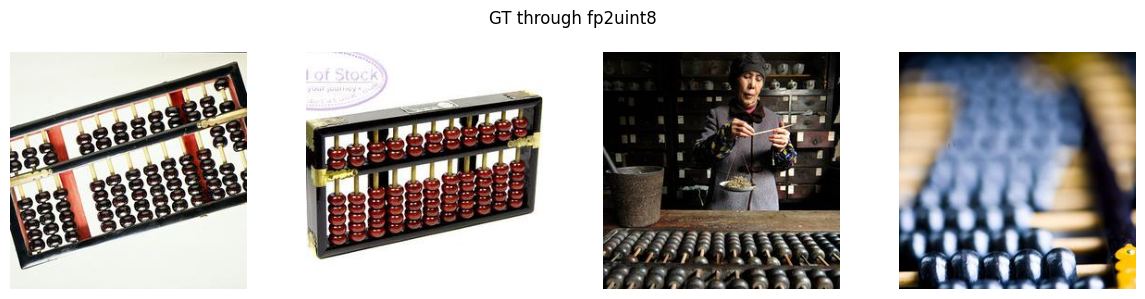

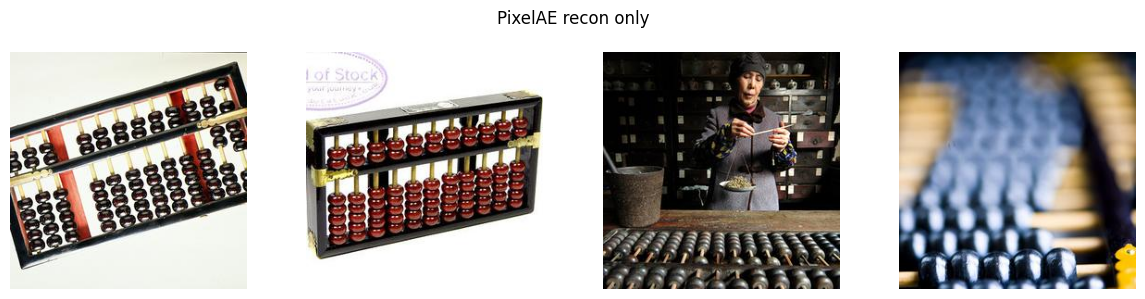

In [45]:
with torch.no_grad():
    x = batch_images.to(DEVICE)                  # normalized [-1,1]
    z = model.vae.encode(x)
    x_rec = model.vae.decode(z)

    show_images(fp2uint8(x).cpu(),      title="GT through fp2uint8")
    show_images(fp2uint8(x_rec).cpu(),  title="PixelAE recon only")






    

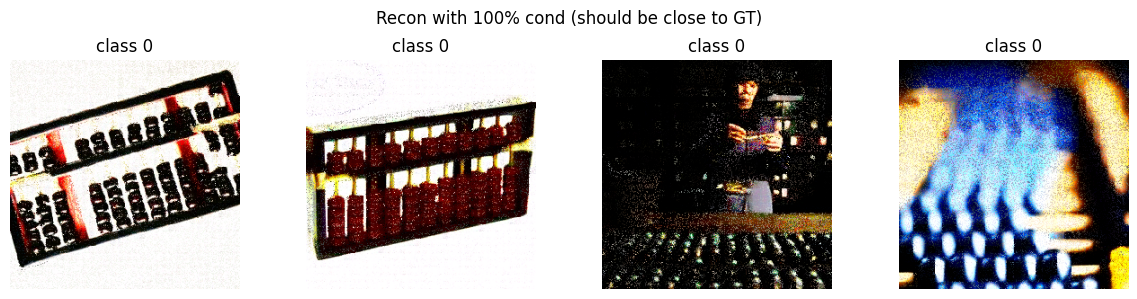

In [43]:
recon_full, cond_full, target_full = reconstruct_sparse_from_gt(
    gt_images=batch_images,
    labels=batch_labels,
    sparsity=0.4,        # 100% of locations “observed”
    cond_fraction=0.5,   # all of those are in cond_mask
    num_steps=50,
    guidance=1,        # also try lowering guidance
    out_height=BASE_RES,
    out_width=BASE_RES,
)

show_images(recon_full, labels=batch_labels, title="Recon with 100% cond (should be close to GT)")


In [7]:
import torch

@torch.no_grad()
def reconstruct_sparse_from_gt(
    gt_images: torch.Tensor,
    labels,  # can be list/tuple or Tensor
    sparsity: float = 0.4,
    cond_fraction: float = 0.5,
    num_steps: int = 50,
    guidance: float = 2.0,
    base_res: int = BASE_RES,
    out_height: int | None = None,
    out_width: int | None = None,
):
    """
    Sparse-conditioned reconstruction from GT images (ImageNet version).
    """
    gt_images = gt_images.to(DEVICE)

    # ---- NEW: handle labels as list or tensor ----
    if isinstance(labels, (list, tuple)):
        labels = torch.tensor(labels, device=DEVICE, dtype=torch.long)
    elif isinstance(labels, torch.Tensor):
        labels = labels.to(DEVICE)
    else:
        raise TypeError(f"labels must be list/tuple or Tensor, got {type(labels)}")

    # if you support super-res:
    if out_height is None or out_width is None:
        out_height = base_res
        out_width = base_res

    B, C, H_in, W_in = gt_images.shape
    assert H_in == base_res and W_in == base_res, \
        f"Expect input GT at base_res={base_res}, got {H_in}x{W_in}"

    # Decide decoder scale (for super-res)
    if out_height == base_res and out_width == base_res:
        scale_h = 1.0
    else:
        scale_h = out_height / float(base_res)
        scale_w = out_width / float(base_res)
        assert abs(scale_h - scale_w) < 1e-6, "Only square scaling supported"
    set_decoder_scale(scale_h)

    # Build high-res GT
    if out_height == base_res and out_width == base_res:
        gt_hr = gt_images
    else:
        gt_hr = F.interpolate(
            gt_images,
            size=(out_height, out_width),
            mode="bilinear",
            align_corners=False,
        )

    # Encode
    x_latent = model.vae.encode(gt_hr)

    # Masks
    cond_mask, target_mask = make_sparsity_masks(
        x_latent,
        sparsity=sparsity,
        cond_fraction=cond_fraction,
    )

    # Conditioner (ImageNet: labels already integer ids)
    condition, uncondition = model.conditioner(labels)

    # Sampler config
    model.diffusion_sampler.guidance = guidance
    model.diffusion_sampler.num_steps = num_steps

    noise = torch.randn_like(x_latent)

    samples_latent = model.diffusion_sampler(
        model.ema_denoiser,
        noise,
        condition,
        uncondition,
        cond_mask=cond_mask,
        x_cond=x_latent,
    )

    recon = model.vae.decode(samples_latent)
    recon = torch.clamp(recon, -1.0, 1.0)
    recon_uint8 = fp2uint8(recon)

    return recon_uint8.cpu(), cond_mask.cpu(), target_mask.cpu()


recon_uint8, cond_mask, target_mask = reconstruct_sparse_from_gt(
    gt_images=batch_images,      # (B,3,H,W), normalized [-1,1]
    labels=batch_labels.tolist(),
    sparsity=0.4,
    cond_fraction=0.5,
    num_steps=50,
    guidance=2.0,
    base_res=256,                # for ImageNet256
)


@torch.no_grad()
def compute_region_mse(
    gt_images,       # (B,3,H,W), normalized [-1,1] (as in training)
    recon_uint8,     # (B,3,H,W), 0..255 from fp2uint8
    cond_mask,       # (B,1,H,W)
    target_mask,     # (B,1,H,W)
):
    device = gt_images.device

    # Convert everything to the same [0,1] space for MSE (easier to reason about)
    gt_01 = (gt_images * 0.5 + 0.5).clamp(0, 1)            # [-1,1] -> [0,1]
    recon_01 = (recon_uint8.float().to(device) / 255.0)    # [0,255] -> [0,1]

    # Per-pixel, per-sample squared error averaged over channels
    # diff2: (B,1,H,W)
    diff2 = (recon_01 - gt_01).pow(2).mean(dim=1, keepdim=True)

    cond_mask = cond_mask.to(device).float()
    target_mask = target_mask.to(device).float()
    obs_mask = torch.clamp(cond_mask + target_mask, 0, 1)
    unobs_mask = 1.0 - obs_mask

    eps = 1e-8

    def masked_mse(mask):
        num = (diff2 * mask).sum()
        den = mask.sum() + eps
        return (num / den).item()

    mse_cond   = masked_mse(cond_mask)
    mse_target = masked_mse(target_mask)
    mse_obs    = masked_mse(obs_mask)
    mse_unobs  = masked_mse(unobs_mask)

    return {
        "mse_cond": mse_cond,
        "mse_target": mse_target,
        "mse_observed": mse_obs,
        "mse_unobserved": mse_unobs,
    }

# ---- Example usage after reconstruct_sparse_from_gt ----

metrics = compute_region_mse(
    gt_images=batch_images.to(DEVICE),
    recon_uint8=recon_uint8,          # output from reconstruct_sparse_from_gt
    cond_mask=cond_mask,
    target_mask=target_mask,
)

print("In-hint  (cond) MSE:     ", metrics["mse_cond"])
print("Target   (supervised) MSE:", metrics["mse_target"])
print("Observed (cond+target):  ", metrics["mse_observed"])
print("Unobserved MSE:          ", metrics["mse_unobserved"])


In-hint  (cond) MSE:      9.721686185630856e-16
Target   (supervised) MSE: 0.04938427358865738
Observed (cond+target):   0.02469213679432869
Unobserved MSE:           0.04912529140710831


## Generate at 4x Super-Resolution (128x128)

The heavy decoder architecture enables generating at higher resolutions
using the same model weights via continuous coordinate embeddings.

In [11]:
print("=" * 50)
print("Generating all 10 classes at 128x128 (4x super-resolution)")
print("=" * 50)

images_128 = sample_class_conditional(
    class_labels=all_classes,
    height=128,
    width=128,
    seed=42,  # Same seed for comparison
    num_steps=50,
    guidance=2.0,
)

print(f"Output shape: {images_128.shape}")
show_images(images_128, labels=CIFAR10_CLASSES, title="CIFAR-10 at 128x128 (4x Super-Res)")
save_grid(images_128, "cifar10_128x128_4x_superres.png", cols=5)

Generating all 10 classes at 128x128 (4x super-resolution)


NameError: name 'all_classes' is not defined

## Side-by-Side Comparison: 32x32 vs 128x128

In [ ]:
# Compare specific classes
comparison_classes = ['cat', 'dog', 'airplane', 'ship']
comparison_labels = [CIFAR10_CLASSES.index(c) for c in comparison_classes]

print("Comparing 32x32 vs Bilinear 128x128 vs NF 128x128")

# Generate at 32x32
imgs_32 = sample_class_conditional(
    class_labels=comparison_labels,
    height=32, width=32,
    seed=123,
)

# Generate at 128x128 (4x)
imgs_128 = sample_class_conditional(
    class_labels=comparison_labels,
    height=128, width=128,
    seed=123,
)

# Bilinear upscale 32->128
imgs_32_upscaled = F.interpolate(
    imgs_32.float() / 255.0,
    size=(128, 128),
    mode='bilinear',
    align_corners=False,
)
imgs_32_upscaled = (imgs_32_upscaled * 255).to(torch.uint8)

# Plot comparison
fig, axes = plt.subplots(len(comparison_classes), 3, figsize=(12, 4 * len(comparison_classes)))

for i, class_name in enumerate(comparison_classes):
    # 32x32 native
    axes[i, 0].imshow(imgs_32[i].permute(1, 2, 0).numpy())
    axes[i, 0].set_title(f"{class_name} - 32x32 Native")
    axes[i, 0].axis('off')
    
    # Bilinear upscale
    axes[i, 1].imshow(imgs_32_upscaled[i].permute(1, 2, 0).numpy())
    axes[i, 1].set_title(f"{class_name} - Bilinear 128x128")
    axes[i, 1].axis('off')
    
    # NF super-res
    axes[i, 2].imshow(imgs_128[i].permute(1, 2, 0).numpy())
    axes[i, 2].set_title(f"{class_name} - NF 128x128 (4x)")
    axes[i, 2].axis('off')

plt.suptitle("32x32 Native vs Bilinear Upscale vs NF Super-Resolution", fontsize=14)
plt.tight_layout()
plt.show()

## Generate Multiple Samples per Class

In [ ]:
# Generate 5 cats at different seeds
print("=" * 50)
print("Generating 5 cats with different seeds at 128x128")
print("=" * 50)

cat_images = []
for seed in [0, 42, 123, 456, 789]:
    img = sample_class_conditional(
        class_labels=['cat'],
        height=128, width=128,
        seed=seed,
    )
    cat_images.append(img)

cat_images = torch.cat(cat_images, dim=0)
show_images(cat_images, labels=['cat'] * 5, title="5 Cats at 128x128")
save_grid(cat_images, "cifar10_cats_128x128.png", cols=5)

## Try Different Super-Resolution Scales

In [ ]:
# Compare different scales: 1x, 2x, 4x, 8x
print("=" * 50)
print("Comparing different super-resolution scales")
print("=" * 50)

scales = [
    (32, "1x (Native)"),
    (64, "2x"),
    (128, "4x"),
    (256, "8x"),
]

class_label = 'airplane'
seed = 42

scale_images = []
scale_titles = []

for resolution, scale_name in scales:
    print(f"Generating at {resolution}x{resolution}...")
    img = sample_class_conditional(
        class_labels=[class_label],
        height=resolution, width=resolution,
        seed=seed,
    )
    scale_images.append(img[0])
    scale_titles.append(f"{resolution}x{resolution} ({scale_name})")

# Display at same visual size
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, (img, title) in enumerate(zip(scale_images, scale_titles)):
    axes[i].imshow(img.permute(1, 2, 0).numpy())
    axes[i].set_title(title)
    axes[i].axis('off')

plt.suptitle(f"{class_label.capitalize()} at Different Resolutions", fontsize=14)
plt.tight_layout()
plt.show()

## Guidance Scale Comparison

In [ ]:
# Compare different guidance scales
print("=" * 50)
print("Comparing different CFG guidance scales at 128x128")
print("=" * 50)

guidance_scales = [1.0, 1.5, 2.0, 3.0, 5.0]
class_label = 'horse'
seed = 42

guidance_images = []
for g in guidance_scales:
    print(f"Guidance = {g}...")
    img = sample_class_conditional(
        class_labels=[class_label],
        height=128, width=128,
        seed=seed,
        guidance=g,
    )
    guidance_images.append(img[0])

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, (img, g) in enumerate(zip(guidance_images, guidance_scales)):
    axes[i].imshow(img.permute(1, 2, 0).numpy())
    axes[i].set_title(f"guidance={g}")
    axes[i].axis('off')

plt.suptitle(f"{class_label.capitalize()} with Different CFG Scales", fontsize=14)
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

### Class-Conditional Generation
- Generate images conditioned on CIFAR-10 class labels (0-9)
- Classifier-Free Guidance (CFG) for improved sample quality

### Super-Resolution via Heavy Decoder
- **Native resolution**: 32x32 (CIFAR-10 training resolution)
- **4x super-resolution**: 128x128 with same model weights
- **Arbitrary scales**: 2x, 4x, 8x, etc.

### How Super-Resolution Works
The heavy decoder uses:
1. **NerfEmbedder**: Continuous coordinate embeddings normalized to [0,1]
2. **Hypernetwork NerfBlocks**: Encoder generates MLP weights that process arbitrary pixel counts
3. **decoder_patch_scaling**: Adjusts decoder patch size to handle higher resolutions

### Key Parameters
| Parameter | Description | Typical Values |
|-----------|-------------|----------------|
| `guidance` | CFG scale | 1.5-3.0 |
| `num_steps` | ODE solver steps | 25-100 |
| `height/width` | Output resolution | 32, 64, 128, 256 |

In [ ]:
print("Done!")